### Setup MLRun

In [ ]:
# !pip install mlrun==0.5.4

In [ ]:
# !pip install --upgrade v3io

In [1]:
import os
from os import path, getenv
import nuclio
from mlrun import new_project, code_to_function, run_local, NewTask, mlconf, import_function, mount_v3io, new_function

project_name = "inference-benchmark"
project_path = path.abspath('project')
project = new_project(name=project_name, context=project_path)
artifact_path = path.abspath('artifacts')
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

print(f'Project path: {project_path}\nProject name: {project_name}')
print(f'Artifacts path: {artifact_path}\nMLRun DB path: {mlconf.dbpath}')

Project path: /User/igz_repos/igz-inference-benchmark/project
Project name: inference-benchmark
Artifacts path: /User/igz_repos/igz-inference-benchmark/artifacts
MLRun DB path: http://mlrun-api:8080


### Build Docker Image

In [2]:
image = f"docker-registry.{os.getenv('IGZ_NAMESPACE_DOMAIN')}:80/inference-benchmarking-demo"

In [3]:
# # Build Docker Image (only needs to be run once)
# build_image = new_function(name="build-image", kind="job")
# build_image.build_config(
#     image=image, base_image="mlrun/ml-models-gpu", commands=["pip install v3io_frames"]
# )
# build_image.deploy(with_mlrun=False)

### Import Functions

In [4]:
project.set_function(func='CreateStream.ipynb',
                     name='create-stream',
                     kind='job')
project.set_function(func='InferenceBenchmark.ipynb',
                     name='inference-benchmark',
                     kind='nuclio')

### Pipeline

In [13]:
%%writefile {path.join(project_path, 'workflow.py')}

import os
from kfp import dsl
from mlrun import mount_v3io

image = f"docker-registry.{os.getenv('IGZ_NAMESPACE_DOMAIN')}:80/inference-benchmarking-demo"
funcs = {}

# Configure function resources and local settings
def init_functions(functions: dict, project=None, secrets=None):
    
    for fn in functions.values():
        # Apply V3IO mount
        fn.apply(mount_v3io(name="model",
                            remote="users/nick/igz_repos/igz-inference-benchmark/models",
                            mount_path="/model"))
        fn.apply(mount_v3io(name="stream",
                            remote="bigdata/dogs_vs_cats/data/",
                            mount_path="/stream"))
            
        # Set resources for jobs
        if fn.to_dict()["kind"] == "job":
            fn.spec.build.image = image
            
        # Set resources for nuclio functions
        elif fn.to_dict()["kind"] == "remote":
            fn.spec.base_spec['spec']['build']['baseImage'] = image
            fn.spec.base_spec['spec']['loggerSinks'] = [{'level': 'info'}]
            fn.spec.min_replicas = 1
            fn.spec.max_replicas = 1
        
    # Apply V3IO trigger
    image_igestion_trigger_spec={
        'kind': 'v3ioStream',
        'url' : f"http://v3io-webapi:8081/bigdata/dogs_vs_cats/stream@processorgrp",
        "password": os.getenv('V3IO_ACCESS_KEY'),  
        'attributes': {"pollingIntervalMs": 500,
            "seekTo": "earliest",
            "readBatchSize": 100,
            "partitions": "0-100",                          
          }
    }
    functions['inference-benchmark'].add_trigger('image-proc', image_igestion_trigger_spec)
#     functions['inference-benchmark'].with_limits(gpus="1", gpu_type='nvidia.com/gpu')

# Create a Kubeflow Pipelines pipeline
@dsl.pipeline(
    name="Inference Benchmark",
    description="Benchmark Model Inferencing with CPUs vs GPUs"
)
def kfpipeline(model_path:str = '/model/dogs_vs_cats_resnet50.pth',
               stream_path:str = "dogs_vs_cats/stream",
               table_path:str = "dogs_vs_cats/table",
               batch_size:int = 32,
               num_batches:int = 8,
               device:str = "cpu"):

#     device = "cuda" if torch.cuda.is_available() else "cpu"
    
    
    inputs = {"stream_path" : stream_path}
    create_stream = funcs['create-stream'].as_step(handler="handler", inputs=inputs, outputs=["stream_url"])
    
    env = {"model_path" : model_path,
           "stream_path" : create_stream.outputs["stream_url"],
           "table_path" : table_path,
           "batch_size" : batch_size,
           "num_batches" : num_batches,
           "device" : device}
    
    # Inference benchmarking on GPU/CPU
    benchmark = funcs['inference-benchmark'].deploy_step(env=env)

Overwriting /User/igz_repos/igz-inference-benchmark/project/workflow.py


### Save Pipeline

In [14]:
project.set_workflow('main', 'workflow.py')
project.save()

### Run Pipeline

In [15]:
run_id = project.run(
    'main',
    arguments={}, 
    artifact_path=path.abspath(path.join('pipeline','{{workflow.uid}}')), 
    dirty=True)

> 2020-12-08 20:57:07,530 [info] Pipeline run id=6dc23082-a893-4443-b02b-ebda7cc6d158, check UI or DB for progress


In [16]:
from mlrun import wait_for_pipeline_completion, get_run_db
wait_for_pipeline_completion(run_id);

### Upload to Stream

In [17]:
%run client/UploadToStream.ipynb

200


### Read KV

In [18]:
import v3io.dataplane
import pandas as pd
v3io_client = v3io.dataplane.Client()
items_cursor = v3io_client.kv.new_cursor(container="bigdata",
                                 table_path="dogs_vs_cats/table",
                                 raise_for_status=[200, 204, 404])
records = [item for item in items_cursor.all()]

df = pd.DataFrame(records)
df["num_batches"] = pd.to_numeric(df["num_batches"])
df["batch_size"] = pd.to_numeric(df["batch_size"])
df["avg_batch_inference_time"] = pd.to_numeric(df["avg_batch_inference_time"])
df["total_inference_time"] = pd.to_numeric(df["total_inference_time"])
df_print = df.set_index(["device", "batch_size", "__name"]).rename_axis(["device", 'batch_size', 'run_id']).sort_index()

print("Inference Times by Run")
display(df_print)
print()
print("Average Inference Times by Batch Size")
df_mean = df_print.groupby(["device", "batch_size"]).mean()
display(df_mean)

Inference Times by Run


num_batches  avg_batch_inference_time  \
device batch_size run_id                                                      
cpu    16         1607372493.6984217            8                  0.662452   
                  1607460873.3855944            8                  0.690585   
                  1607460886.4499474            8                  0.737905   
       32         1607461074.4271812            8                  1.751511   

                                      total_inference_time  
device batch_size run_id                                    
cpu    16         1607372493.6984217              6.374100  
                  1607460873.3855944              6.411161  
                  1607460886.4499474              6.851224  
       32         1607461074.4271812             15.812861


Average Inference Times by Batch Size


num_batches  avg_batch_inference_time  total_inference_time
device batch_size                                                             
cpu    16                    8                  0.696981              6.545495
       32                    8                  1.751511             15.812861

### Plot Results

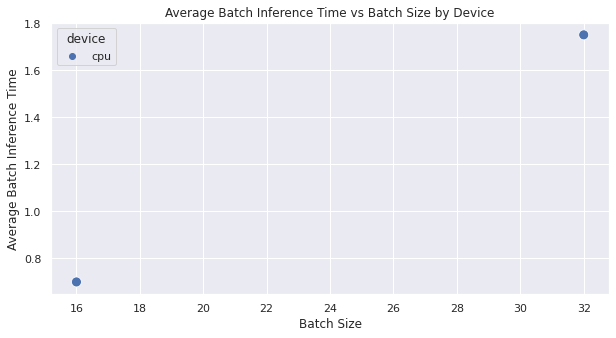

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

df_plot = df.groupby(["batch_size", "device"]).mean()
plt.figure(figsize=(10,5))
batch_chart = sns.scatterplot(
    x="batch_size",
    y="avg_batch_inference_time",
    hue='device',
    s=100,
    data=df_plot)
plt.title('Average Batch Inference Time vs Batch Size by Device');
plt.xlabel("Batch Size");
plt.ylabel("Average Batch Inference Time");